# LSTM Autoencoder 실습 및 연습문제

이 노트북은 다음으로 구성됩니다:
1. **LSTM Autoencoder 예시**: 완전한 구현 및 학습 예시
2. **연습문제**: CNN-LSTM-AE 구현 과제

---

## 1. 필요한 라이브러리 import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 재현성을 위한 시드 설정
np.random.seed(42)
torch.manual_seed(42)

# device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 2. 데이터 생성 및 전처리

실습을 위해 정상 패턴과 이상 패턴을 가진 시계열 데이터를 생성합니다.

In [ ]:
def generate_normal_sequences(n_samples=1000, seq_len=50, n_features=3):
    """
    정상 시계열 데이터 생성 (사인파 + 코사인파 + 작은 노이즈)
    """
    sequences = []
    for _ in range(n_samples):
        t = np.linspace(0, 4*np.pi, seq_len)
        feature1 = np.sin(t) + np.random.normal(0, 0.1, seq_len)
        feature2 = np.cos(t) + np.random.normal(0, 0.1, seq_len)
        feature3 = np.sin(2*t) * 0.5 + np.random.normal(0, 0.1, seq_len)
        
        seq = np.stack([feature1, feature2, feature3], axis=1)
        sequences.append(seq)
    
    return np.array(sequences)

def generate_anomaly_sequences(n_samples=100, seq_len=50, n_features=3):
    """
    이상 시계열 데이터 생성 (급격한 변화 포함)
    """
    sequences = []
    for _ in range(n_samples):
        t = np.linspace(0, 4*np.pi, seq_len)
        
        # 정상 패턴에 이상 추가
        feature1 = np.sin(t) + np.random.normal(0, 0.1, seq_len)
        feature2 = np.cos(t) + np.random.normal(0, 0.1, seq_len)
        feature3 = np.sin(2*t) * 0.5 + np.random.normal(0, 0.1, seq_len)
        
        # 랜덤한 위치에 급격한 변화 추가
        anomaly_start = np.random.randint(10, seq_len - 10)
        anomaly_length = np.random.randint(5, 15)
        
        feature1[anomaly_start:anomaly_start+anomaly_length] += np.random.uniform(2, 4)
        feature2[anomaly_start:anomaly_start+anomaly_length] -= np.random.uniform(2, 4)
        feature3[anomaly_start:anomaly_start+anomaly_length] *= np.random.uniform(3, 5)
        
        seq = np.stack([feature1, feature2, feature3], axis=1)
        sequences.append(seq)
    
    return np.array(sequences)

# 데이터 생성
print("데이터 생성 중...")
normal_train = generate_normal_sequences(n_samples=800, seq_len=50, n_features=3)
normal_val = generate_normal_sequences(n_samples=200, seq_len=50, n_features=3)
anomaly_test = generate_anomaly_sequences(n_samples=100, seq_len=50, n_features=3)

print(f"정상 학습 데이터: {normal_train.shape}")
print(f"정상 검증 데이터: {normal_val.shape}")
print(f"이상 테스트 데이터: {anomaly_test.shape}")

데이터 생성 중...
정상 학습 데이터: (800, 50, 3)
정상 검증 데이터: (200, 50, 3)
이상 테스트 데이터: (100, 50, 3)


### 데이터 시각화

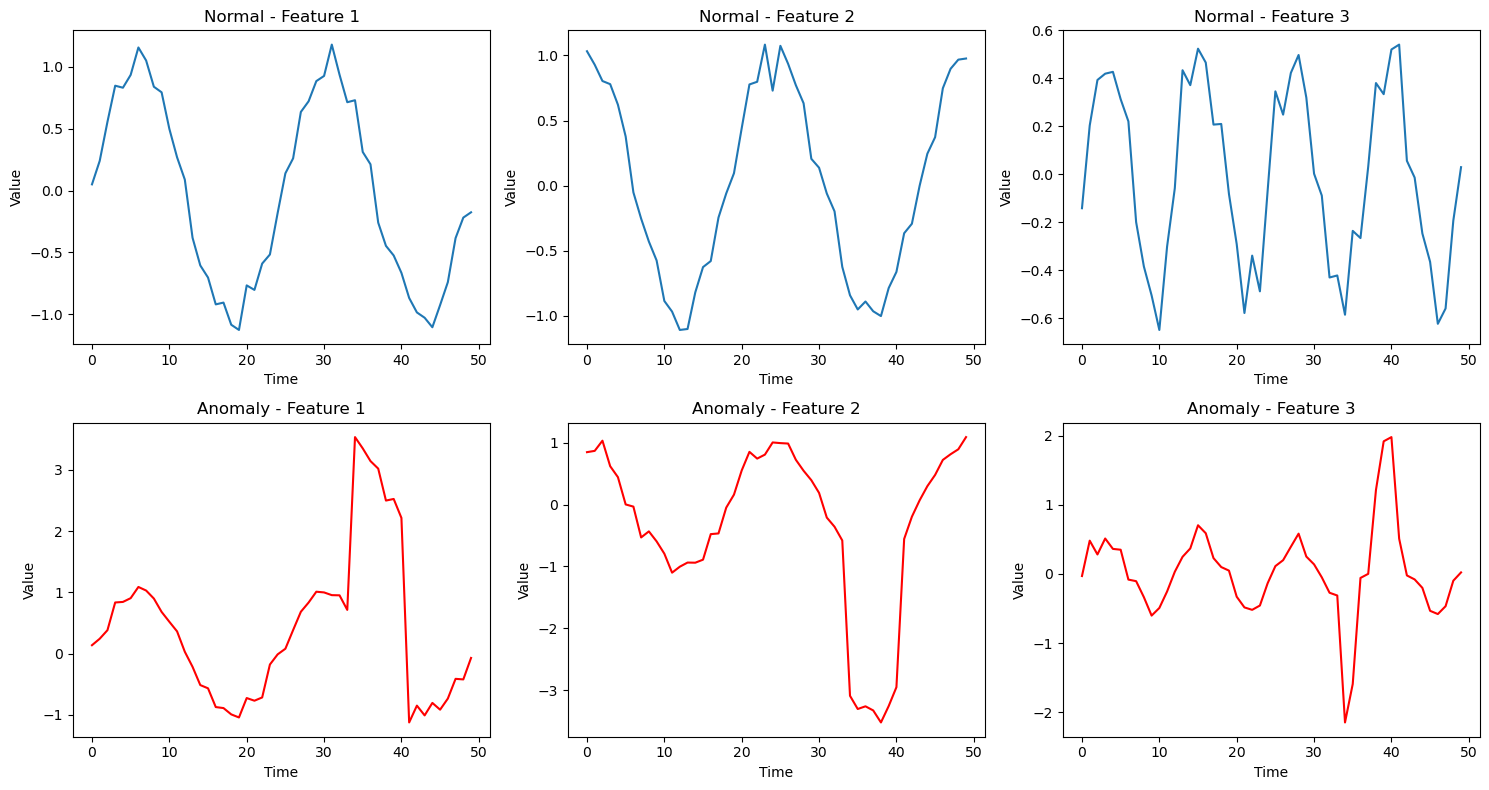

In [ ]:
# 정상 데이터와 이상 데이터 비교
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# 정상 데이터 샘플
for i in range(3):
    axes[0, i].plot(normal_train[0, :, i])
    axes[0, i].set_title(f'Normal - Feature {i+1}')
    axes[0, i].set_xlabel('Time')
    axes[0, i].set_ylabel('Value')

# 이상 데이터 샘플
for i in range(3):
    axes[1, i].plot(anomaly_test[0, :, i], color='red')
    axes[1, i].set_title(f'Anomaly - Feature {i+1}')
    axes[1, i].set_xlabel('Time')
    axes[1, i].set_ylabel('Value')

plt.tight_layout()
plt.show()

### 데이터 정규화

In [ ]:
# StandardScaler 적용
scaler = StandardScaler()

# 학습 데이터로 scaler fit
normal_train_reshaped = normal_train.reshape(-1, normal_train.shape[-1])
scaler.fit(normal_train_reshaped)

# 모든 데이터 변환
normal_train_scaled = scaler.transform(normal_train.reshape(-1, 3)).reshape(normal_train.shape)
normal_val_scaled = scaler.transform(normal_val.reshape(-1, 3)).reshape(normal_val.shape)
anomaly_test_scaled = scaler.transform(anomaly_test.reshape(-1, 3)).reshape(anomaly_test.shape)

print("데이터 정규화 완료")
print(f"Train mean: {normal_train_scaled.mean():.4f}, std: {normal_train_scaled.std():.4f}")

데이터 정규화 완료
Train mean: 0.0000, std: 1.0000


### Dataset 및 DataLoader 생성

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = torch.FloatTensor(sequences)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx]

# Dataset 생성
train_dataset = TimeSeriesDataset(normal_train_scaled)
val_dataset = TimeSeriesDataset(normal_val_scaled)
test_dataset = TimeSeriesDataset(anomaly_test_scaled)

# DataLoader 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 25
Val batches: 7
Test batches: 4


---

## 3. LSTM Autoencoder 모델 정의 (예시)

LSTM Autoencoder는 Encoder-Decoder 구조로 이루어져 있습니다:
- **Encoder**: 입력 시퀀스를 잠재 표현(latent representation)으로 압축
- **Decoder**: 잠재 표현으로부터 원본 시퀀스를 재구성

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout, seq_len):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len

        self.encoder_lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            dropout=dropout,
            batch_first=True
        )

    def forward(self, input_seq):
        # input_seq: (B, T, D)
        encoder_outputs, (h_n, c_n) = self.encoder_lstm(input_seq)

        # last hidden state -> latent representation
        latent = h_n.squeeze(0)  # (B, H)
        latent_seq = latent.unsqueeze(1).repeat(1, input_seq.size(1), 1)  # (B, T, H)

        return latent_seq, encoder_outputs


class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, dropout, seq_len, use_output_activation):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.use_output_activation = use_output_activation

        self.decoder_lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            dropout=dropout,
            batch_first=True
        )

        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Sigmoid()

    def forward(self, latent_seq):
        # latent_seq: (B, T, H)
        decoder_outputs, (h_n, c_n) = self.decoder_lstm(latent_seq)
        reconstructed_seq = self.output_layer(decoder_outputs)  # (B, T, D)

        if self.use_output_activation:
            reconstructed_seq = self.activation(reconstructed_seq)

        return reconstructed_seq, h_n


class LSTMAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout, seq_len, use_output_activation=False):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len

        self.encoder = Encoder(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            dropout=dropout,
            seq_len=seq_len
        )

        self.decoder = Decoder(
            output_dim=input_dim,
            hidden_dim=hidden_dim,
            dropout=dropout,
            seq_len=seq_len,
            use_output_activation=use_output_activation
        )

    def forward(self, input_seq, return_latent=False, return_encoder_outputs=False):
        latent_seq, encoder_outputs = self.encoder(input_seq)
        reconstructed_seq, last_hidden = self.decoder(latent_seq)

        if return_latent:
            return reconstructed_seq, last_hidden
        elif return_encoder_outputs:
            return reconstructed_seq, encoder_outputs

        return reconstructed_seq

### 모델 초기화

In [ ]:
# 하이퍼파라미터
input_dim = 3  # feature 개수
hidden_dim = 64  # LSTM hidden dimension
seq_len = 50  # sequence length
dropout = 0.2

# 모델 생성
model = LSTMAutoEncoder(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    dropout=dropout,
    seq_len=seq_len,
    use_output_activation=False
).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

LSTMAutoEncoder(
  (encoder): Encoder(
    (encoder_lstm): LSTM(3, 64, batch_first=True, dropout=0.2)
  )
  (decoder): Decoder(
    (decoder_lstm): LSTM(64, 64, batch_first=True, dropout=0.2)
    (output_layer): Linear(in_features=64, out_features=3, bias=True)
    (activation): Sigmoid()
  )
)

Total parameters: 51139


c:\Users\LEEYS\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


## 4. 학습 함수 정의

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        batch = batch.to(device)
        
        # Forward pass
        reconstructed = model(batch)
        loss = criterion(reconstructed, batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)


def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            
            # Forward pass
            reconstructed = model(batch)
            loss = criterion(reconstructed, batch)
            
            total_loss += loss.item()
    
    return total_loss / len(dataloader)


def compute_reconstruction_error(model, dataloader, device):
    """
    각 샘플의 재구성 오차 계산 (이상 탐지용)
    """
    model.eval()
    errors = []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            reconstructed = model(batch)
            
            # 샘플별 MSE 계산
            batch_errors = torch.mean((batch - reconstructed) ** 2, dim=(1, 2))
            errors.extend(batch_errors.cpu().numpy())
    
    return np.array(errors)

## 5. 모델 학습

In [ ]:
# 학습 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

# 학습 이력 저장
train_losses = []
val_losses = []

print("모델 학습 시작...\n")

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss:.6f}")
        print(f"  Val Loss: {val_loss:.6f}")

print("\n학습 완료!")

모델 학습 시작...

Epoch [10/50]
  Train Loss: 0.040841
  Val Loss: 0.040859
Epoch [20/50]
  Train Loss: 0.041014
  Val Loss: 0.040645
Epoch [30/50]
  Train Loss: 0.039423
  Val Loss: 0.039037
Epoch [40/50]
  Train Loss: 0.039361
  Val Loss: 0.039362
Epoch [50/50]
  Train Loss: 0.041347
  Val Loss: 0.038978

학습 완료!


### 학습 곡선 시각화

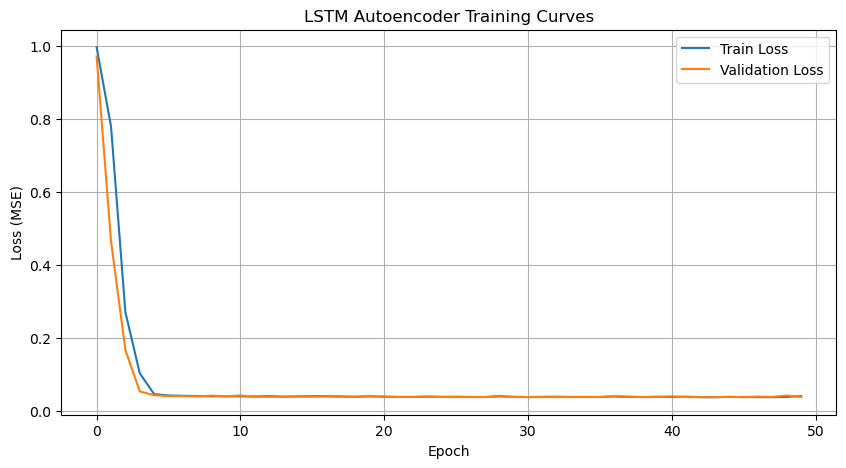

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('LSTM Autoencoder Training Curves')
plt.legend()
plt.grid(True)
plt.show()

## 6. 이상 탐지 성능 평가

In [ ]:
# 재구성 오차 계산
print("재구성 오차 계산 중...")
normal_errors = compute_reconstruction_error(model, val_loader, device)
anomaly_errors = compute_reconstruction_error(model, test_loader, device)

print(f"정상 데이터 재구성 오차 - Mean: {normal_errors.mean():.6f}, Std: {normal_errors.std():.6f}")
print(f"이상 데이터 재구성 오차 - Mean: {anomaly_errors.mean():.6f}, Std: {anomaly_errors.std():.6f}")

재구성 오차 계산 중...
정상 데이터 재구성 오차 - Mean: 0.038803, Std: 0.005397
이상 데이터 재구성 오차 - Mean: 3.266495, Std: 1.358152


### 재구성 오차 분포 시각화

C:\Users\LEEYS\AppData\Local\Temp\ipykernel_18428\2539705443.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal_errors, anomaly_errors], labels=['Normal', 'Anomaly'])


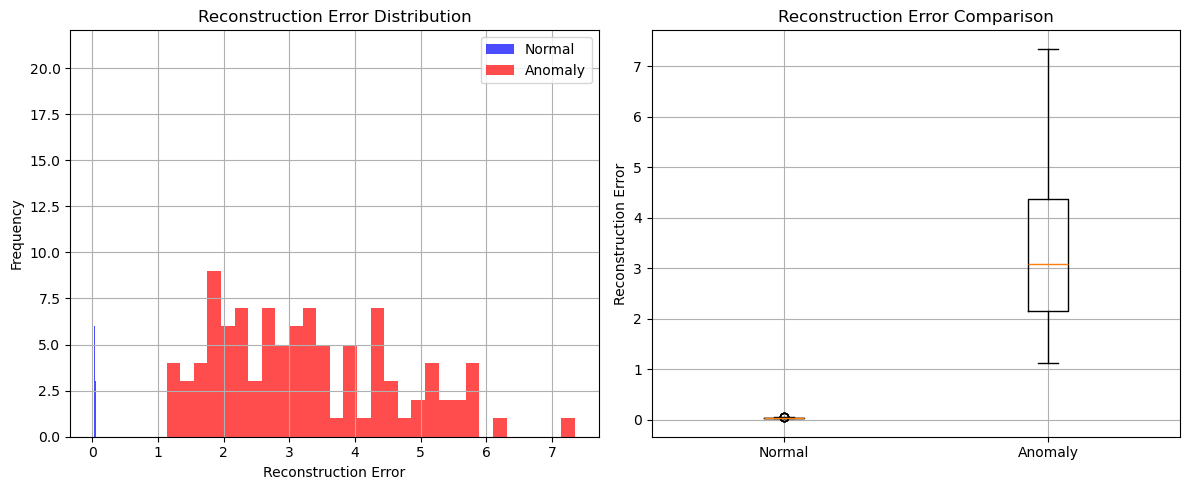

In [ ]:
plt.figure(figsize=(12, 5))

# 히스토그램
plt.subplot(1, 2, 1)
plt.hist(normal_errors, bins=30, alpha=0.7, label='Normal', color='blue')
plt.hist(anomaly_errors, bins=30, alpha=0.7, label='Anomaly', color='red')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.grid(True)

# 박스플롯
plt.subplot(1, 2, 2)
plt.boxplot([normal_errors, anomaly_errors], labels=['Normal', 'Anomaly'])
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Comparison')
plt.grid(True)

plt.tight_layout()
plt.show()

### 임계값 기반 이상 탐지

In [ ]:
# 임계값 설정 (정상 데이터 평균 + 2*표준편차)
threshold = normal_errors.mean() + 2 * normal_errors.std()
print(f"이상 탐지 임계값: {threshold:.6f}")

# 이상 탐지 수행
normal_predictions = (normal_errors > threshold).astype(int)
anomaly_predictions = (anomaly_errors > threshold).astype(int)

# 성능 평가
normal_accuracy = 1 - normal_predictions.mean()
anomaly_accuracy = anomaly_predictions.mean()

print(f"\n정상 데이터 정확도: {normal_accuracy:.2%}")
print(f"이상 데이터 탐지율: {anomaly_accuracy:.2%}")

이상 탐지 임계값: 0.049597

정상 데이터 정확도: 96.00%
이상 데이터 탐지율: 100.00%


## 7. 재구성 결과 시각화

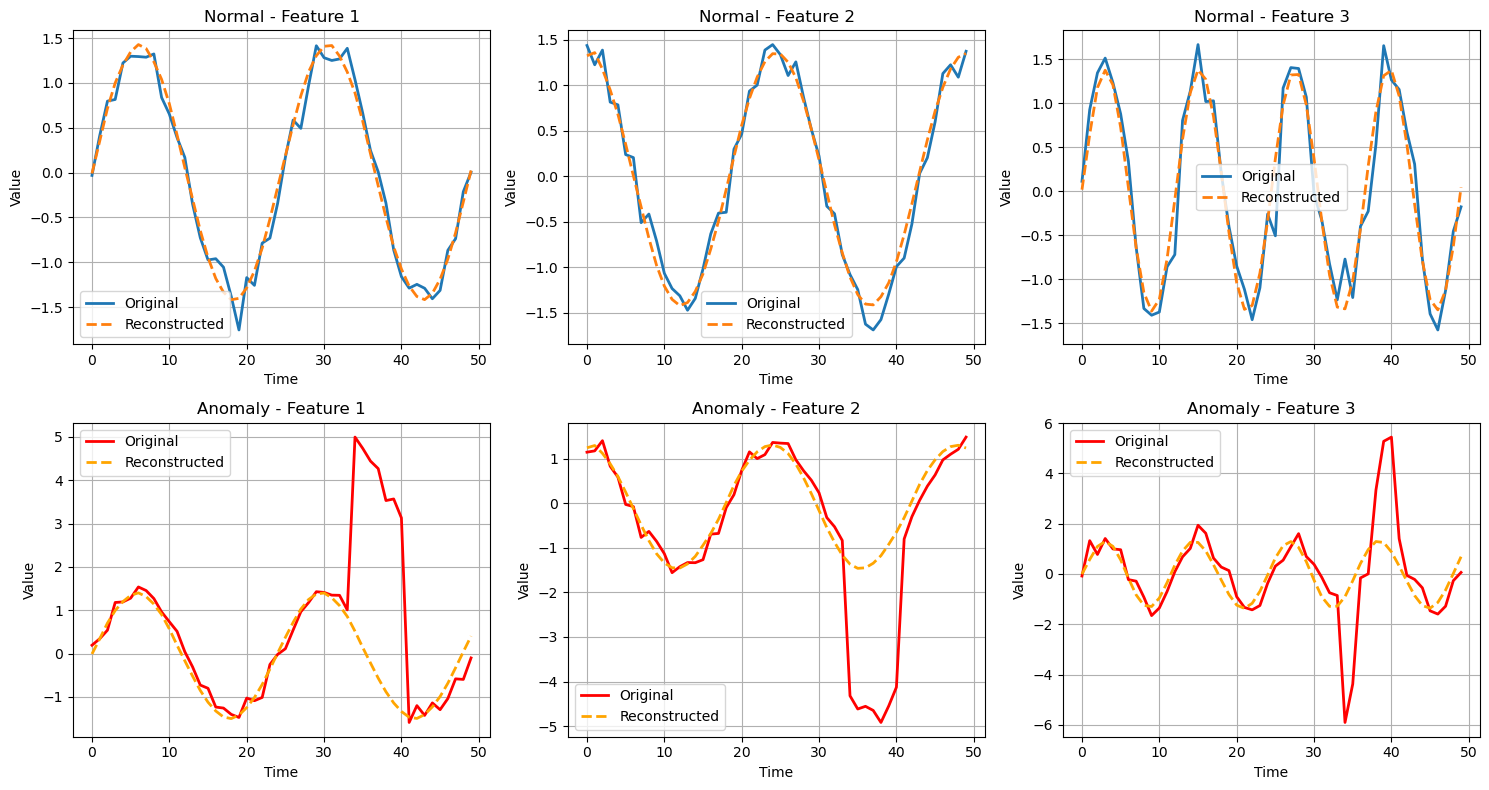

In [ ]:
# 정상 데이터 재구성 예시
model.eval()
with torch.no_grad():
    sample_normal = torch.FloatTensor(normal_val_scaled[0:1]).to(device)
    reconstructed_normal = model(sample_normal).cpu().numpy()[0]

    sample_anomaly = torch.FloatTensor(anomaly_test_scaled[0:1]).to(device)
    reconstructed_anomaly = model(sample_anomaly).cpu().numpy()[0]

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# 정상 데이터
for i in range(3):
    axes[0, i].plot(normal_val_scaled[0, :, i], label='Original', linewidth=2)
    axes[0, i].plot(reconstructed_normal[:, i], label='Reconstructed', linestyle='--', linewidth=2)
    axes[0, i].set_title(f'Normal - Feature {i+1}')
    axes[0, i].set_xlabel('Time')
    axes[0, i].set_ylabel('Value')
    axes[0, i].legend()
    axes[0, i].grid(True)

# 이상 데이터
for i in range(3):
    axes[1, i].plot(anomaly_test_scaled[0, :, i], label='Original', linewidth=2, color='red')
    axes[1, i].plot(reconstructed_anomaly[:, i], label='Reconstructed', linestyle='--', linewidth=2, color='orange')
    axes[1, i].set_title(f'Anomaly - Feature {i+1}')
    axes[1, i].set_xlabel('Time')
    axes[1, i].set_ylabel('Value')
    axes[1, i].legend()
    axes[1, i].grid(True)

plt.tight_layout()
plt.show()

---

# 연습문제: CNN-LSTM Autoencoder 구현

위의 LSTM Autoencoder 예시를 참고하여 **CNN-LSTM Autoencoder**를 구현하세요.

## 요구사항

### 1. CNN-LSTM Encoder 구현
- 1D Convolution layer로 시작하여 국소 패턴 추출
- CNN 출력을 LSTM에 입력하여 시간적 의존성 학습
- 최종 hidden state를 잠재 표현으로 사용

### 2. CNN-LSTM Decoder 구현  
- LSTM으로 시퀀스 재구성
- 1D Transposed Convolution 또는 Upsampling을 사용하여 원본 차원으로 복원

### 3. 전체 모델 구현
- Encoder와 Decoder를 결합한 CNN-LSTM Autoencoder 클래스 생성

### 4. 학습 및 평가
- 위와 동일한 데이터로 학습
- 학습 곡선 시각화
- 이상 탐지 성능 평가
- LSTM AE와 성능 비교

## 힌트

```python
# CNN-LSTM Encoder 구조 예시
class CNNLSTMEncoder(nn.Module):
    def __init__(self, input_dim, cnn_channels, kernel_size, lstm_hidden_dim, dropout):
        super().__init__()
        
        # 1D Convolution
        self.conv1d = nn.Conv1d(
            in_channels=input_dim,
            out_channels=cnn_channels,
            kernel_size=kernel_size,
            padding=kernel_size // 2
        )
        self.relu = nn.ReLU()
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=cnn_channels,
            hidden_size=lstm_hidden_dim,
            batch_first=True,
            dropout=dropout
        )
    
    def forward(self, x):
        # x: (B, T, D)
        # TODO: CNN expects (B, D, T) - permute 필요
        # TODO: CNN forward
        # TODO: LSTM expects (B, T, C) - permute 다시
        # TODO: LSTM forward
        pass
```

## 평가 기준

1. **모델 구현**: CNN과 LSTM이 올바르게 결합되었는가?
2. **학습 성공**: 모델이 정상적으로 학습되는가?
3. **성능**: LSTM AE 대비 이상 탐지 성능이 개선되었는가?
4. **코드 품질**: 가독성과 구조가 좋은가?

---

## 연습문제 풀이 공간

아래 셀에 코드를 작성하세요.

###### B(batch size) : 한번에 학습시키는 데이터의 묶음 크기
###### T(time step) : 시퀀스의 길이
###### D(dimension, depth) : 각 시점에서의 데이터의 차원 (특징 수)
###### C(Channel) : CNN에서 주로 쓰이며, 이미지의 색상(RGB)이나 필터의 개수

기본적인 1D CNN 구조 (시계열 데이터 예시)  

[입력 데이터]
  (Batch_Size, Sequence_Length, Features)
  예: (32, 100, 10)  -> 32개의 샘플, 각 샘플은 100개 시점, 각 시점은 10개 특징을 가짐

        ↓ (permute 필요!)

[1D CNN 입력 형식]
  (Batch_Size, Features, Sequence_Length)
  예: (32, 10, 100) -> PyTorch Conv1D의 표준 입력 형식 (B, C_in, L_in)

        ↓
[Conv1D Layer]
  - 필터가 시퀀스 길이를 따라 이동하며 지역 특징 추출
  - 출력: (Batch_Size, New_Features, New_Sequence_Length)
  - 예: (32, 64, 98)  -> 64개의 새로운 특징 맵, 길이 98 (필터 크기, 스트라이드에 따라 변함)

        ↓
[ReLU (활성화 함수)]
  - 비선형성 추가

        ↓
[MaxPooling1D / AvgPooling1D]
  - 특징 맵의 차원을 줄여 과적합 방지 및 주요 특징 강조
  - 출력: (Batch_Size, New_Features, Reduced_Sequence_Length)
  - 예: (32, 64, 49)

        ↓ (Flatten)

[Flatten Layer]
  - 다차원 데이터를 1차원 벡터로 펼침 (예측 모델의 입력으로 사용하기 위함)
  - 출력: (Batch_Size, Total_Flattened_Features)
  - 예: (32, 64 * 49 = 3136)

        ↓
[Linear (Dense) Layer]
  - 특징 벡터를 기반으로 최종 예측 또는 분류
  - 출력: (Batch_Size, Num_Classes) 또는 (Batch_Size, Output_Dim)
  - 예: (32, 2) -> 2개 클래스 분류 또는 2개 값 예측


In [ ]:
# TODO: CNN-LSTM Encoder 구현
class CNNLSTMEncoder(nn.Module):
    def __init__(self, input_dim, cnn_channels, kernel_size, lstm_hidden_dim, output_dim, dropout):
        super(CNNLSTMEncoder, self).__init__()
        self.input_dim = input_dim
        self.cnn_channels = cnn_channels
        self.kernal_size = kernel_size
        self.lstm_hidden_dim = lstm_hidden_dim

        # 1D Convolution : 시퀀스의 지역적 특징 추출
        # 입력 차원 : (Batch, Input_Dim, Seq_Len)
        self.encoder_conv1d = nn.Conv1d(
            in_channels = input_dim,
            out_channerls = cnn_channels,
            kernal_size = kernel_size,
            padding = kernel_size // 2
        )
        self.relu = nn.ReLU()

        # LTSM : CNN이 뽑은 특징들의 시간적 흐름 학습
        # 입력 차원 : (Batch, Seq_len, CNN_Channels)
        self.encoder_lstm = nn.LTSM(
            input_size = cnn_channels,
            hidden_size = lstm_hidden_dim,
            batch_first = True,
            dropout = dropout
        )

        # Fully Connected Layer : 최종 예측
        # self.fc = nn.Linear(lstm_hidden_dim, output_dim)
    
    def forward(self, x):
        # input_seq : (B, T, D)
        x = x.permute(0, 2, 1)

        #1. CNN 통과 : (B, D, T)
        x = self.encoder_conv1d(x)
        x = self.relu(x) # (B, CNN_channel, Seq_len)

        # 2. LSTM 통과 : (B, T, C)
        x = x.permute(0, 2, 1)
        encoder_outputs, (h_n, c_n) = self.encoder_lstm(x)
        latent = h_n[-1] # 마지막 층의 hidden state 추출(Latent Vector) #(B, H)
        latent_seq = latent.unsqueeze(1).repeat(1, self.seq_len, 1) # Repeat_vector : 디코더 입력을 위해 시퀀스 길이 만큼 반복 # (B, H) -> (B, 1, H) -> (B, T, H)
        return latent_seq, encoder_outputs

In [ ]:
# TODO: CNN-LSTM Decoder 구현
class CNNLSTMDecoder(nn.Module):
    def __init__(self, output_dim, cnn_channels, kernel_size, lstm_hidden_dim, dropout, seq_len):
        super().__init__()
        # 여기에 코드를 작성하세요
        pass
    
    def forward(self, x):
        # 여기에 코드를 작성하세요
        pass

In [ ]:
# TODO: CNN-LSTM Autoencoder 구현
class CNNLSTMAutoEncoder(nn.Module):
    def __init__(self, input_dim, cnn_channels, kernel_size, lstm_hidden_dim, dropout, seq_len):
        super().__init__()
        # 여기에 코드를 작성하세요
        pass
    
    def forward(self, x):
        # 여기에 코드를 작성하세요
        pass

In [ ]:
# TODO: 모델 초기화
# 하이퍼파라미터를 설정하고 모델을 생성하세요

In [ ]:
# TODO: 모델 학습
# 위의 train_epoch, validate 함수를 활용하여 학습하세요

In [ ]:
# TODO: 학습 곡선 시각화

In [ ]:
# TODO: 이상 탐지 성능 평가

In [ ]:
# TODO: LSTM AE vs CNN-LSTM AE 성능 비교
# 두 모델의 재구성 오차를 비교하는 그래프를 그리세요

## 보너스 과제

1. **다양한 CNN 구조 실험**: 여러 개의 Conv layer를 쌓거나 다른 kernel size를 실험해보세요
2. **Attention 메커니즘 추가**: Encoder-Decoder 사이에 attention을 추가해보세요
3. **실제 데이터 적용**: 실제 시계열 데이터(주가, 센서 데이터 등)에 적용해보세요
4. **하이퍼파라미터 튜닝**: Grid search 또는 Random search로 최적의 하이퍼파라미터를 찾아보세요